In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import polars as pl
import pandas as pd
from sklearn.base import clone
from copy import deepcopy
import optuna
from scipy.optimize import minimize
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
from sklearn.impute import SimpleImputer, KNNImputer
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import re
from colorama import Fore, Style

from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import *
from sklearn.metrics import *

SEED = 42
n_splits = 5

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Viewing the data

### Training Data
The training set has 3960 samples with 80 features excluding 'sii' and 'id'. By viewing the training dataset, we can see that there seem to be some NaN features in some rows.

In [2]:
season_dtype = pl.Enum(['Spring', 'Summer', 'Fall', 'Winter'])

train = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)

test = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)

train

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,…,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
str,enum,i64,i64,enum,i64,enum,f64,f64,f64,f64,i64,i64,i64,enum,i64,i64,i64,enum,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,enum,i64,f64,f64,…,f64,f64,f64,f64,f64,enum,f64,enum,f64,enum,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,enum,i64,i64,enum,i64,i64
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,…,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,"""Fall""",5,4,4,0,4,0,0,4,0,0,4,0,4,4,4,4,4,4,2,4,55,null,null,null,"""Fall""",3,2
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,…,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""Fall""",46,64,"""Summer""",0,0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,…,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",5,2,2,1,2,1,1,2,1,1,1,0,1,1,1,0,2,2,1,1,28,"""Fall""",38,54,"""Summer""",2,0
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,…,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",4,2,4,0,5,1,0,3,2,2,3,0,3,0,0,3,4,3,4,1,44,"""Summer""",31,45,"""Winter""",0,1
"""0016bb22""","""Spring""",18,1,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,"""Summer""",1.04,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ff8a2de4""","""Fall""",13,0,"""Spring""",60,"""Fall""",16.36246,59.5,82.4,null,71,70,104,null,null,null,null,"""Fall""",16,0,18.0,1,19.9,2,10,1,8.0,1,9.0,1,12.0,1,"""Fall""",3,4.52277,16.3642,…,33.3709,17.9797,66.2889,29.779,52.832,null,null,"""Winter""",3.26,"""Winter""",3,3,3,2,3,2,2,2,2,1,2,0,2,0,1,0,2,1,1,0,32,"""Winter""",35,50,"""Fall""",1,1
"""ffa9794a""","""Winter""",10,0,null,null,"""Spring""",18.764678,53.5,76.4,27.0,60,78,118,null,null,null,null,"""Spring""",0,0,null,null,null,null,4,0,0.0,0,0.0,0,12.0,1,"""Spring""",null,null,null,…,null,nu

### Missing Values
All columns seem to have a large amount of missing values, except for 'id' as well as 'sex', 'age' and season of enrollment. Currently, I suppose we can replace the missing values with it's neightbors using **KNNImputer**. From the definition of scikit-learn: 
_"Imputation for completing missing values using k-Nearest Neighbors. Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set. Two samples are close if the features that neither is missing are close."_

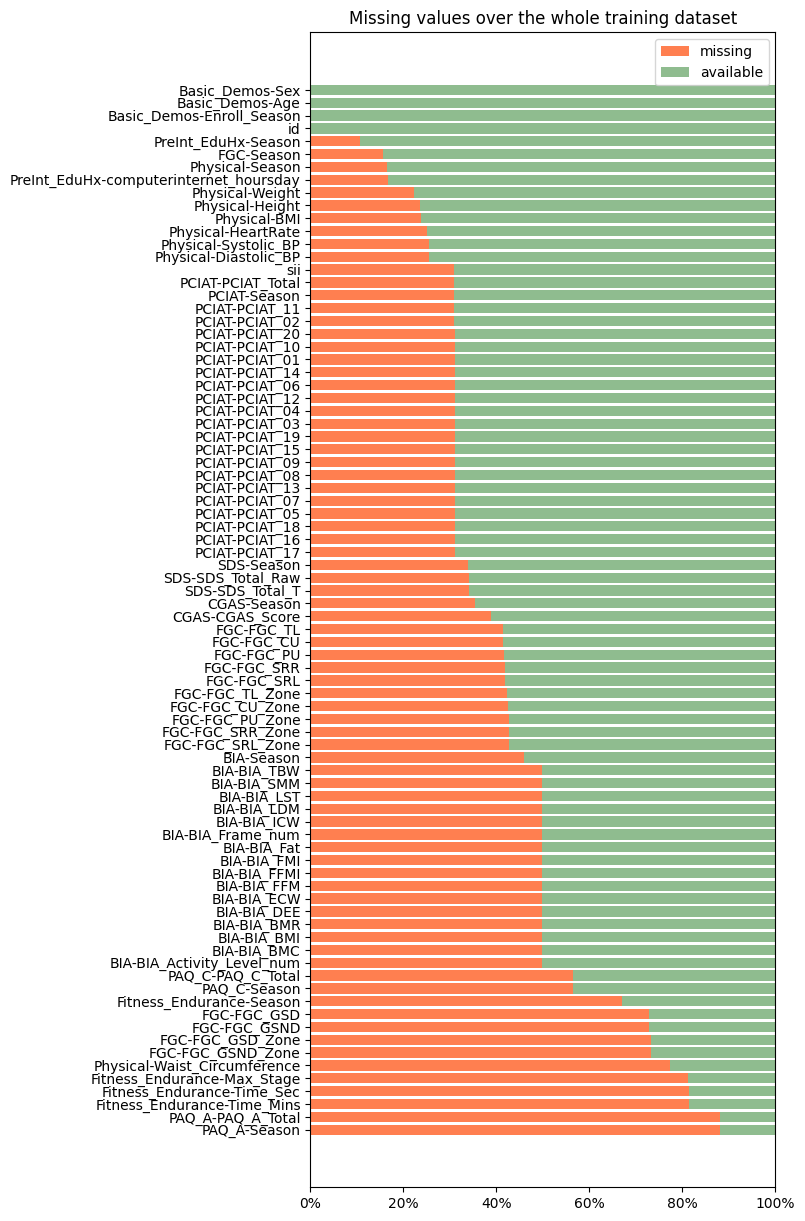

In [3]:
missing_count = (
    train
    .null_count()
    .transpose(include_header=True,
               header_name='feature',
               column_names=['null_count'])
    .sort('null_count', descending=True)
    .with_columns((pl.col('null_count') / len(train)).alias('null_ratio'))
)
plt.figure(figsize=(6, 15))
plt.title('Missing values over the whole training dataset')
plt.barh(np.arange(len(missing_count)), missing_count.get_column('null_ratio'), color='coral', label='missing')
plt.barh(np.arange(len(missing_count)), 
         1 - missing_count.get_column('null_ratio'),
         left=missing_count.get_column('null_ratio'),
         color='darkseagreen', label='available')
plt.yticks(np.arange(len(missing_count)), missing_count.get_column('feature'))
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.legend()
plt.show()

### Test Set

The test set does not have an PCIAT columns, as PCIAT columns can be used to directly map to 'sii'

- We should try to predict the target without the PCIAT features
- We can either directly predict **'sii'** using some type of classification **or** use a regression model to predict **PCIAT_Total** which can then be mapped to **'sii'**

In [4]:
(train
 .select(pl.col('PCIAT-PCIAT_Total'))
 .group_by(train.get_column('sii'))
 .agg(pl.col('PCIAT-PCIAT_Total').min().alias('PCIAT-PCIAT_Total min'),
      pl.col('PCIAT-PCIAT_Total').max().alias('PCIAT-PCIAT_Total max'),
      pl.col('PCIAT-PCIAT_Total').len().alias('count'))
 .sort('sii')
)

sii,PCIAT-PCIAT_Total min,PCIAT-PCIAT_Total max,count
i64,i64,i64,u32
null,null,null,1224
0,0,30,1594
1,31,49,730
2,50,79,378
3,80,93,34


### Actigraphy

Looking at the file of participant id=417c91e, we can see that:
- She moves alot as enmo > 2 everyday
- She is in an environment where lux exceeds 2500 every day.

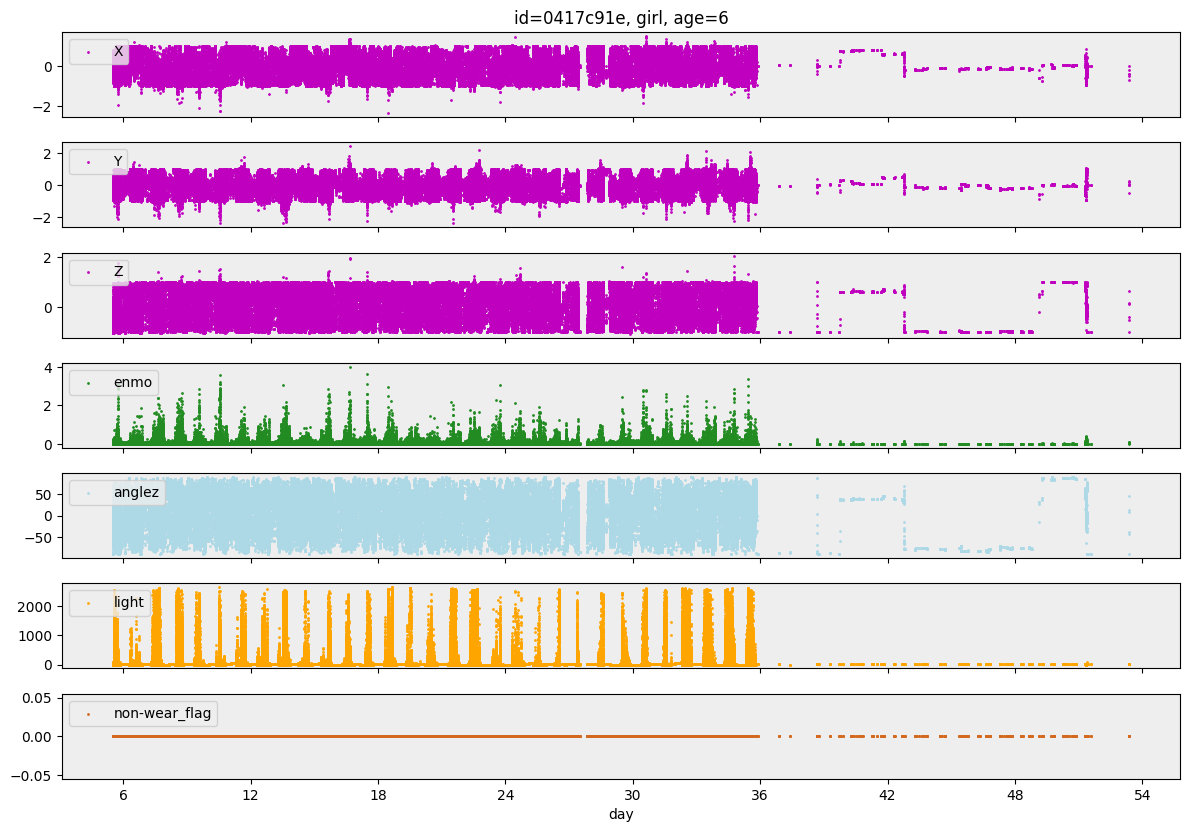

In [5]:
# View the actigraphy
def analyze_actigraphy(id, only_one_week=False, small=False):
    actigraphy = pl.read_parquet(f'/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id={id}/part-0.parquet')
    day = actigraphy.get_column('relative_date_PCIAT') + actigraphy.get_column('time_of_day') / 86400e9
    sample = train.filter(pl.col('id') == id)
    age = sample.get_column('Basic_Demos-Age').item()
    sex = ['boy', 'girl'][sample.get_column('Basic_Demos-Sex').item()]
    actigraphy = (
        actigraphy
        .with_columns(
            (day.diff() * 86400).alias('diff_seconds'),
            (np.sqrt(np.square(pl.col('X')) + np.square(pl.col('Y')) + np.square(pl.col('Z'))).alias('norm'))
        )
    )

    if only_one_week:
        start = np.ceil(day.min())
        mask = (start <= day.to_numpy()) & (day.to_numpy() <= start + 7*3)
        mask &= ~ actigraphy.get_column('non-wear_flag').cast(bool).to_numpy()
    else:
        mask = np.full(len(day), True)
        
    if small:
        timelines = [
            ('enmo', 'forestgreen'),
            ('light', 'orange'),
        ]
    else:
        timelines = [
            ('X', 'm'),
            ('Y', 'm'),
            ('Z', 'm'),
#             ('norm', 'c'),
            ('enmo', 'forestgreen'),
            ('anglez', 'lightblue'),
            ('light', 'orange'),
            ('non-wear_flag', 'chocolate')
    #         ('diff_seconds', 'k'),
        ]
        
    _, axs = plt.subplots(len(timelines), 1, sharex=True, figsize=(12, len(timelines) * 1.1 + 0.5))
    for ax, (feature, color) in zip(axs, timelines):
        ax.set_facecolor('#eeeeee')
        ax.scatter(day.to_numpy()[mask],
                   actigraphy.get_column(feature).to_numpy()[mask],
                   color=color, label=feature, s=1)
        ax.legend(loc='upper left', facecolor='#eeeeee')
        if feature == 'diff_seconds':
            ax.set_ylim(-0.5, 20.5)
    axs[-1].set_xlabel('day')
    axs[-1].xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    axs[0].set_title(f'id={id}, {sex}, age={age}')
    plt.show()

analyze_actigraphy('0417c91e', only_one_week=False)

A boy who only sees daylight once a month and does not move much

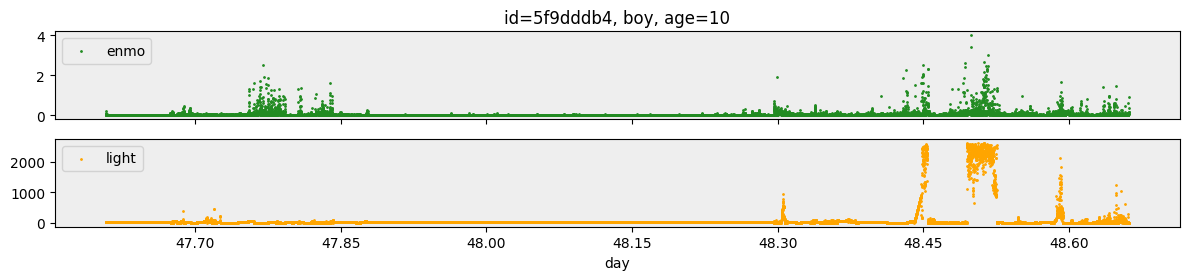

In [6]:
analyze_actigraphy('5f9dddb4', small=True)

Strange ramps in between the lights $\rightarrow$ Maybe some missing data was filled in.

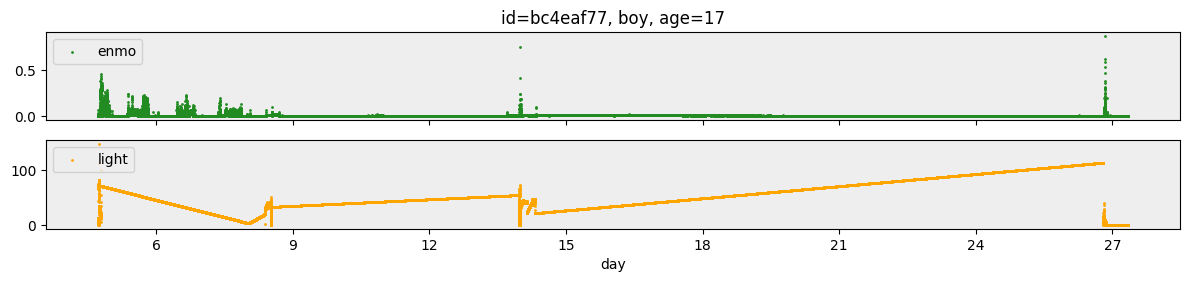

In [7]:
analyze_actigraphy('bc4eaf77', small=True)

We can conclude that the actigraphy need some data cleaning

In [8]:
# Extract important features from actigraphy
def extract_ts_features(df):
    # Turns timestamp into date format
    df['timestamp'] = pd.to_datetime(df['relative_date_PCIAT'], unit='D') + pd.to_timedelta(df['time_of_day'])
    # removes all non-wear flags days
    df = df[df['non-wear_flag'] == 0]
    df['velocity'] = np.sqrt(data['X']**2 + data['Y']**2 + data['Z']**2)
    df['distance_travelled_per5s'] = df['velocity'] * 5
    df['date'] = df['timestamp'].dt.date
    hour = pd.to_datetime(df['time_of_day']).dt.hour

    return df

In [9]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim*3),
            nn.ReLU(),
            nn.Linear(encoding_dim*3, encoding_dim*2),
            nn.ReLU(),
            nn.Linear(encoding_dim*2, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim*2),
            nn.ReLU(),
            nn.Linear(input_dim*2, input_dim*3),
            nn.ReLU(),
            nn.Linear(input_dim*3, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
        
def perform_autoencoder(df, encoding_dim=50, epochs=50, batch_size=32):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    data_tensor = torch.FloatTensor(df_scaled)
    
    input_dim = data_tensor.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters())
    
    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i : i + batch_size]
            optimizer.zero_grad()
            reconstructed = autoencoder(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}]')
                 
    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()
        
    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    
    return df_encoded

train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)

train_ts_encoded = perform_autoencoder(df_train, encoding_dim=60, epochs=100, batch_size=32)
test_ts_encoded = perform_autoencoder(df_test, encoding_dim=60, epochs=100, batch_size=32)

time_series_cols = train_ts_encoded.columns.tolist()
train_ts_encoded["id"]=train_ts["id"]
test_ts_encoded['id']=test_ts["id"]

train = pd.merge(train, train_ts_encoded, how="left", on='id')
test = pd.merge(test, test_ts_encoded, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

100%|██████████| 2/2 [00:00<00:00,  8.75it/s]


Epoch [10/100], Loss: 1.6141]
Epoch [20/100], Loss: 1.5234]
Epoch [30/100], Loss: 1.5099]
Epoch [40/100], Loss: 1.5009]
Epoch [50/100], Loss: 1.4943]
Epoch [60/100], Loss: 1.4860]
Epoch [70/100], Loss: 1.4412]
Epoch [80/100], Loss: 1.3636]
Epoch [90/100], Loss: 1.3636]
Epoch [100/100], Loss: 1.3534]
Epoch [10/100], Loss: 1.0184]
Epoch [20/100], Loss: 0.5990]
Epoch [30/100], Loss: 0.4271]
Epoch [40/100], Loss: 0.4271]
Epoch [50/100], Loss: 0.4271]
Epoch [60/100], Loss: 0.4271]
Epoch [70/100], Loss: 0.4271]
Epoch [80/100], Loss: 0.4271]
Epoch [90/100], Loss: 0.4271]
Epoch [100/100], Loss: 0.4271]


In [10]:
train_ts_encoded.head()

imputer = KNNImputer(n_neighbors=3)
numeric_cols = train.select_dtypes(include=['int32', 'int64', 'float64', 'int64']).columns
imputed_data = imputer.fit_transform(train[numeric_cols])
train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)
# round the imputed sii's
train_imputed['sii'] = train_imputed['sii'].round().astype(int)
for col in train.columns:
    if col not in numeric_cols:
        train_imputed[col] = train[col]
        
train = train_imputed

In [11]:
featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 
          'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def update(df):
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
        
train = update(train)
test = update(test)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in cat_c:
    mapping_train = create_mapping(col, train)
    mapping_test = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping_train).astype(int)
    test[col] = test[col].replace(mapping_test).astype(int)

# drop rows with thresholds dropna(thresh=N):
# Retains rows with at least N non-null values.
# If a row has fewer than N non-null values, it will be dropped

print(f'Train Shape : {train.shape} || Test Shape : {test.shape}')

Train Shape : (3960, 119) || Test Shape : (20, 118)


In [12]:
def feature_engineering(df):
    season_cols = [col for col in df.columns if 'Season' in col]
    df = df.drop(season_cols, axis=1) 
    df['Age_and_BMI'] = df['Basic_Demos-Age'] * df['Physical-BMI']
    df['BP_Difference'] = df['Physical-Systolic_BP'] - df['Physical-Diastolic_BP']
    df['BMI_Per_Weight'] = df['Physical-BMI'] / df['Physical-Weight']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BMI_Height_Ratio'] = df['Physical-BMI'] / df['Physical-Height']
    df['HeartRate_to_Weight'] = df['Physical-HeartRate'] / df['Physical-Weight']
    df['Frame_to_BMI'] = df['BIA-BIA_Frame_num'] / df['Physical-BMI']


    return df
    
train = feature_engineering(train)
train = train.dropna(thresh=10, axis=0)
test = feature_engineering(test)

train.shape

(3960, 117)

In [13]:
test.shape

(20, 116)

In [14]:
# if np.any(np.isinf(train)):
#   train = train.replace([np.inf, -np.inf], np.nan)

In [15]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

def TrainML(model_class, test_data):
    
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead') # Nelder-Mead | # Powell
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission,model

In [16]:
# Testing Parameters for first run
Params = {'learning_rate': 0.03884249148676395, 'max_depth': 12, 'num_leaves': 413, 'min_data_in_leaf': 14,
           'feature_fraction': 0.7987976913702801, 'bagging_fraction': 0.7602261703576205, 'bagging_freq': 2, 
           'lambda_l1': 4.735462555910575, 'lambda_l2': 4.735028557007343e-06} # CV : 0.4094 | LB : 0.471

Light = lgb.LGBMRegressor(**Params,random_state=SEED, verbose=-1,n_estimators=200)
Submission,model = TrainML(Light, test)

Training Folds: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]

Mean Train QWK --> 0.8742
Mean Validation QWK ---> 0.5262
----> || Optimized QWK SCORE ::  0.561


In [17]:
Submission.to_csv('submission.csv', index=False)
print(Submission['sii'].value_counts())

sii
1    13
0     7
Name: count, dtype: int64


<Axes: title={'center': 'LightGBM Feature Importance (Gain)'}, xlabel='Feature importance', ylabel='Features'>

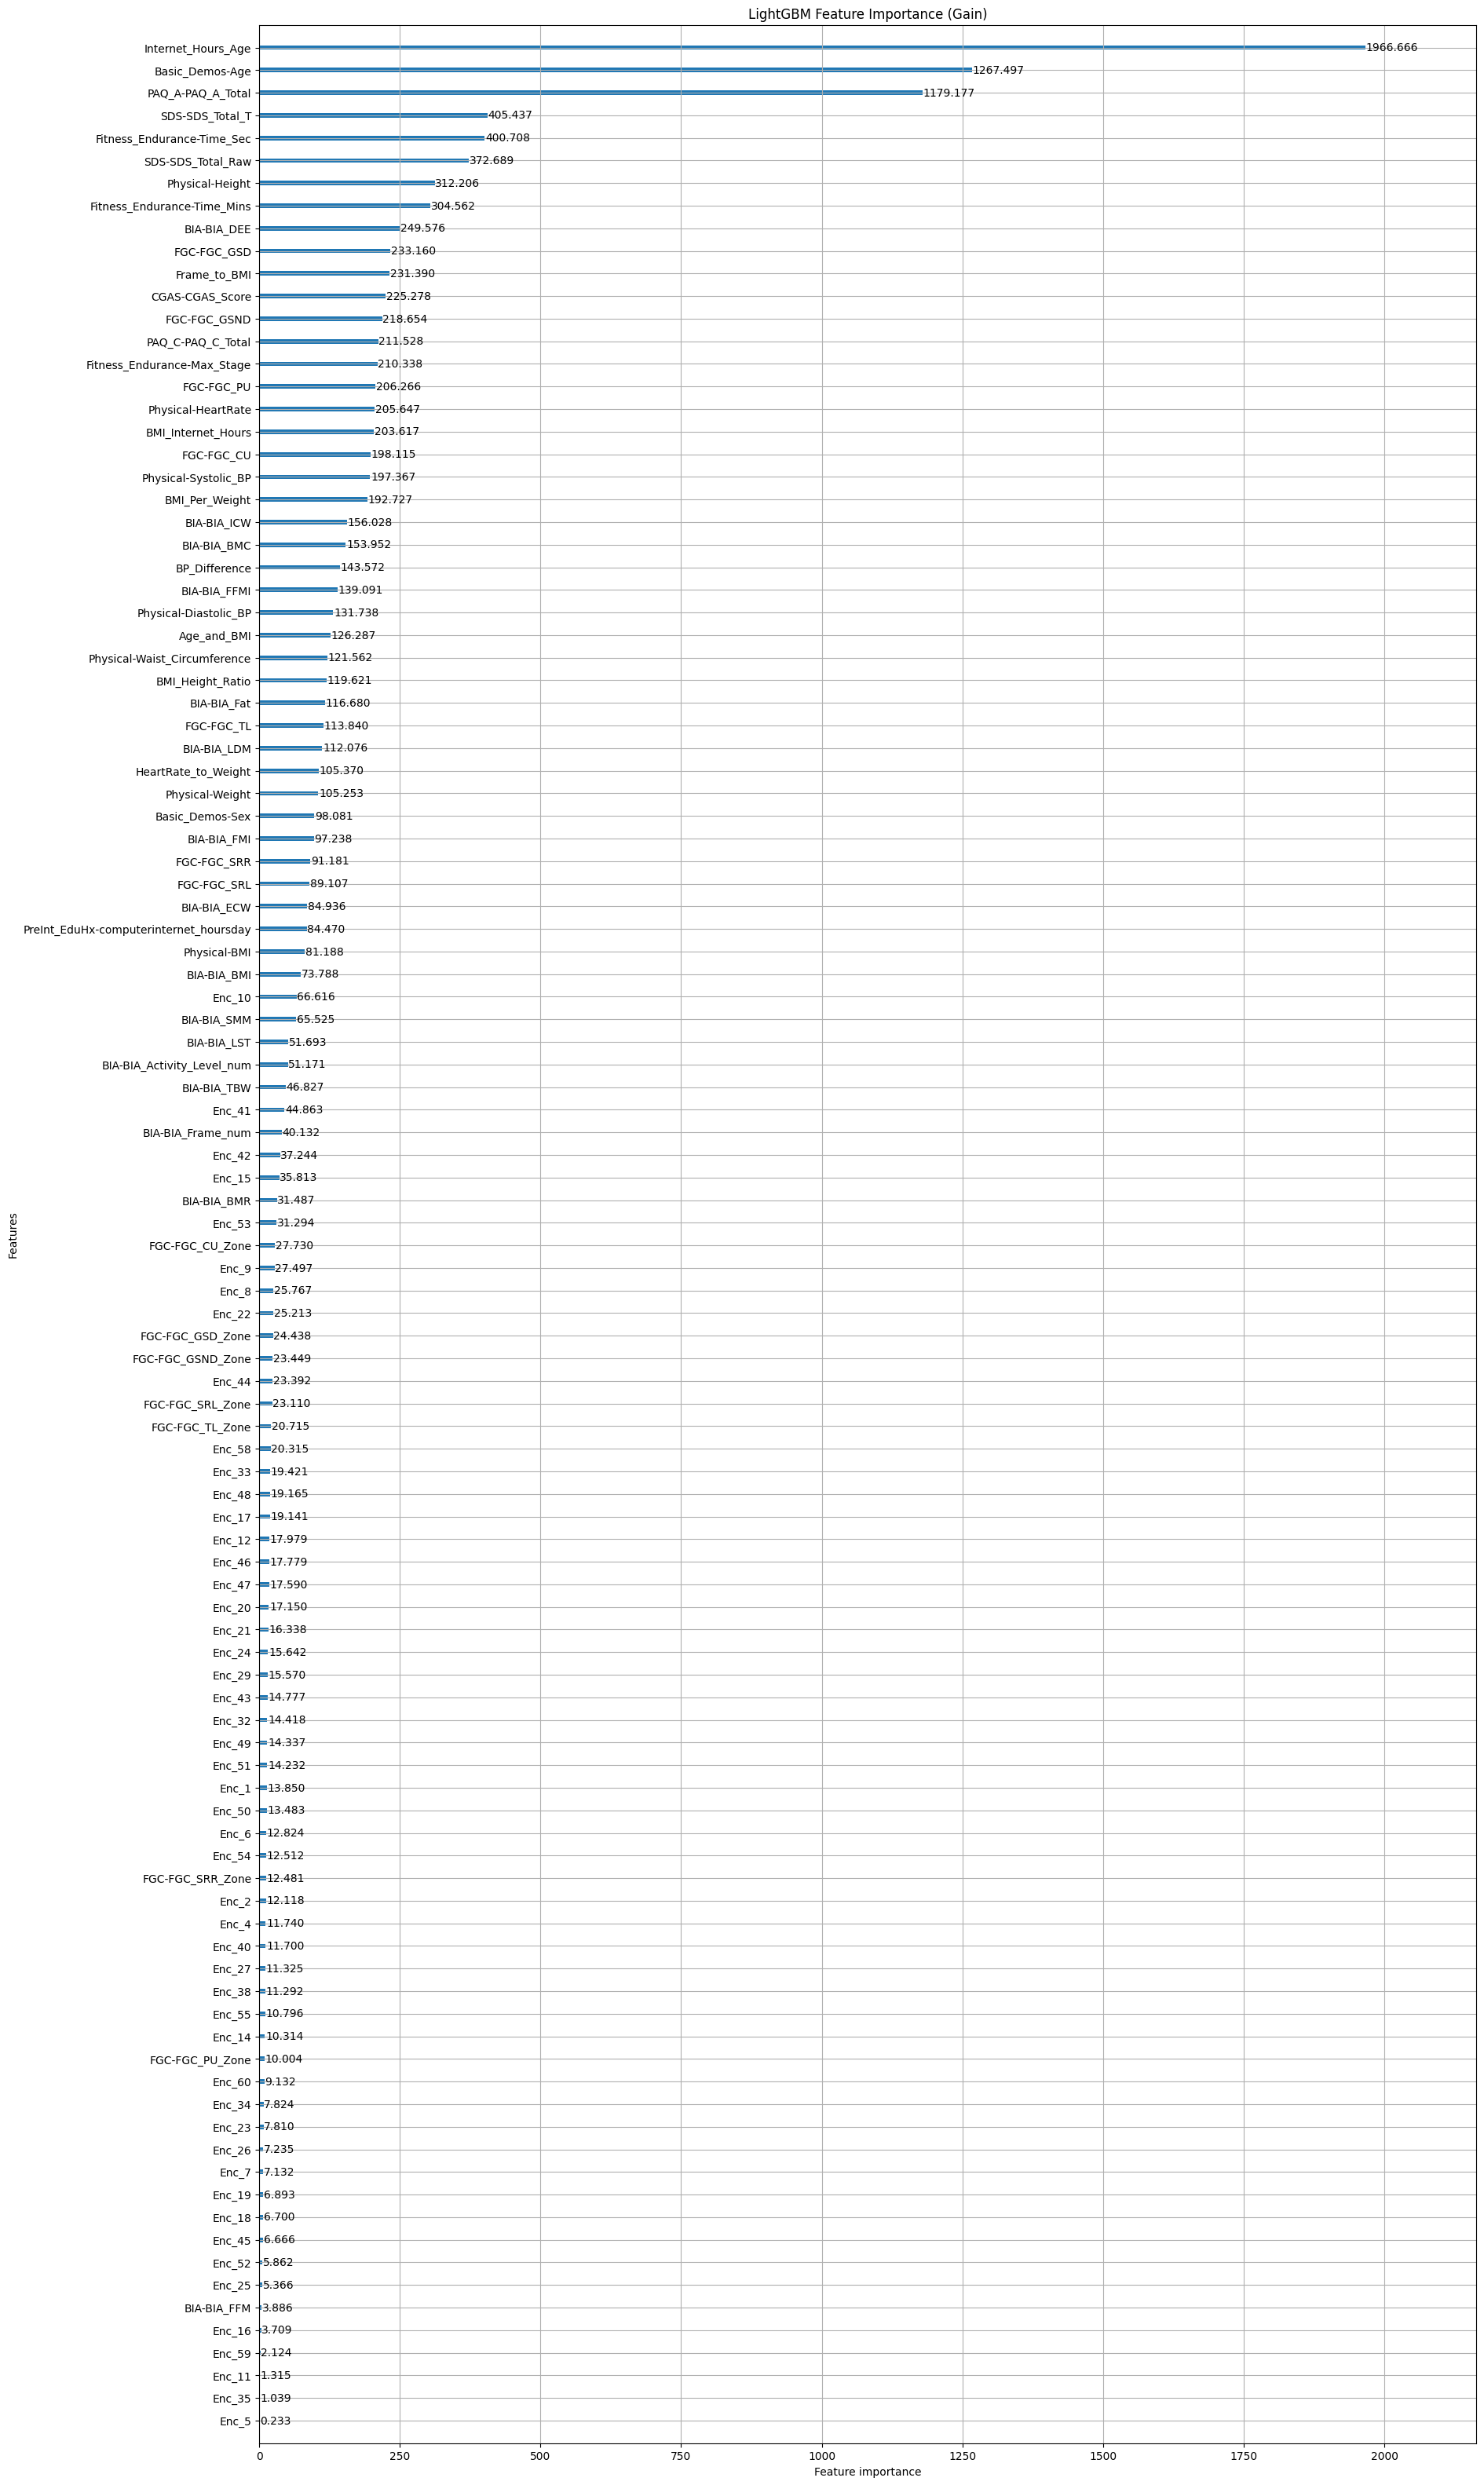

In [18]:
# plot feature importances for feature selection
lgb.plot_importance(model, importance_type="gain", figsize=(20,40), title="LightGBM Feature Importance (Gain)")